In [460]:
import numpy as np
from sklearn import datasets
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [461]:
import matplotlib.pyplot as plt
%matplotlib inline

In [462]:
df = pd.read_csv('life_expectancy.csv')

data_arr = np.array(df.iloc[:]).T[3:-1].T.astype(np.float64)


In [463]:
new_data_arr = []
for data in data_arr:
  if np.sum(data) == np.sum(data):
    new_data_arr.append(data)

new_data_arr = np.array(new_data_arr)

new_data_arr_norm = new_data_arr / np.mean(new_data_arr, axis = 0)
p = np.random.permutation(len(new_data_arr_norm))
new_data_arr_norm = new_data_arr_norm[p]

In [464]:
tr_data = new_data_arr_norm[0:1200]
print(np.mean(tr_data))
ts_data = new_data_arr_norm[1200:]
print(np.mean(ts_data))

0.9895140662314847
1.0280247673100649


In [465]:
tr_data_x = torch.from_numpy(tr_data.T[1:-1].T.astype(np.float32))
tr_data_y = torch.from_numpy(np.expand_dims(tr_data.T[0].T, axis = -1).astype(np.float32))

print(tr_data_x)
print(tr_data_y)


ts_data_x = torch.from_numpy(ts_data.T[1:-1].T.astype(np.float32))
ts_data_y = torch.from_numpy(np.expand_dims(ts_data.T[0].T, axis = -1).astype(np.float32))

tensor([[2.5741, 0.8601, 0.8758,  ..., 0.0043, 1.7523, 1.7116],
        [0.1070, 0.0307, 0.9464,  ..., 0.0232, 0.3917, 0.4075],
        [0.1367, 0.0614, 0.6243,  ..., 0.0466, 0.3711, 0.3464],
        ...,
        [1.7715, 0.1843, 0.1346,  ..., 0.0030, 1.8348, 1.7931],
        [0.5529, 0.0307, 0.9265,  ..., 0.2982, 0.3917, 0.3871],
        [0.8560, 0.1229, 0.1169,  ..., 0.1617, 1.9997, 1.9153]])
tensor([[0.6796],
        [1.0505],
        [1.0274],
        ...,
        [0.8961],
        [1.1385],
        [1.0490]])


In [466]:
#2 layer BNN 
num_features = 16
regression_out=1

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=num_features, out_features=128),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=128, out_features=regression_out),
    #nn.Tanh(),
)

In [467]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [468]:
kl_weight = 0.1

In [469]:
mse_per_iteration=[]
kl_per_iteration=[]
cost_arr=[]

for step in range(3000):
    pre = model(tr_data_x)
    mse = mse_loss(pre,tr_data_y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    mse_per_iteration.append(mse.item())
    kl_per_iteration.append(kl.item())
    cost_arr.append(cost.item())
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.02, KL : 1.11


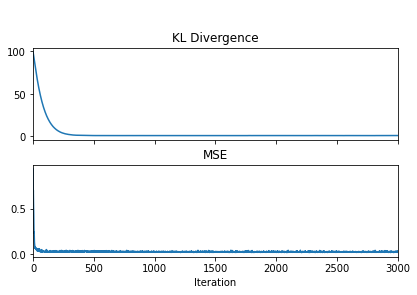

In [470]:
fig, axs = plt.subplots(2,sharex=True)
fig.suptitle(' ')
fig.tight_layout(pad=1.5)
axs[0].plot(kl_per_iteration)
axs[0].set_title('KL Divergence')
axs[1].plot(mse_per_iteration)
axs[1].set_title('MSE')
axs[1].set(xlabel='Iteration')

plt.xlim([0, 3000])

for ax in axs:
    ax.label_outer()

Text(0.5, 1.0, 'Moving STD of MSE')

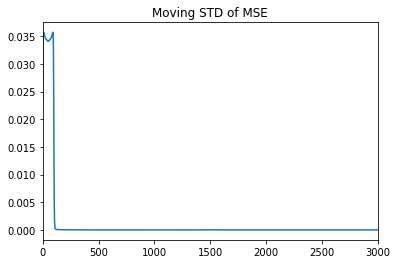

In [471]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

mse_np=np.array(mse_per_iteration)

a = np.var(rolling_window(mse_np, 100), axis=-1)

plt.xlim([0, 3000])

plt.plot(a)
plt.title(label="Moving STD of MSE")

In [472]:
np.sum((((model(ts_data_x)-ts_data_y)*69.3).detach().numpy())**2)/len(ts_data_y)

83.74821652282851

In [473]:
np.std(ts_data_y.detach().numpy()*69.3)

8.8141365

-0.044693146


(array([  8.,  36.,  94., 142., 105.,  44.,  17.,   1.,   0.,   2.]),
 array([-0.36838585, -0.279248  , -0.19011013, -0.10097228, -0.01183442,
         0.07730344,  0.16644129,  0.25557914,  0.34471703,  0.43385488,
         0.52299273], dtype=float32),
 <BarContainer object of 10 artists>)

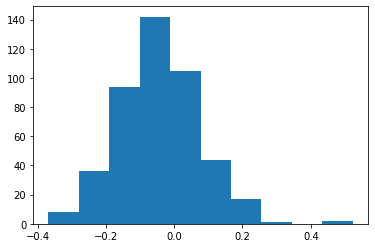

In [474]:
acc=((model(ts_data_x)-ts_data_y))
acc=acc.detach().numpy()
print(np.mean(acc))
plt.hist(acc)

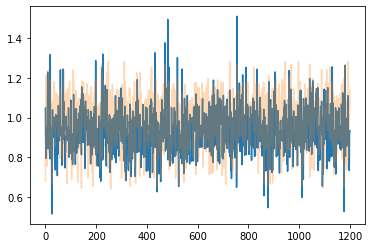

In [478]:
trrx=model(tr_data_x).detach().numpy()
trry=tr_data_y.detach().numpy()

plt.plot(trrx)
plt.plot(trry,alpha=0.3)

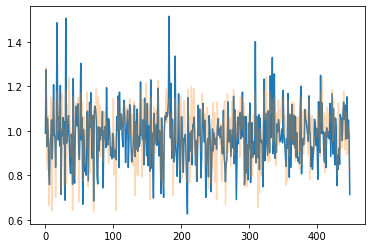

In [476]:
tssx=model(ts_data_x).detach().numpy()
tssy=ts_data_y.detach().numpy()

plt.plot(tssx)
plt.plot(tssy,alpha=0.3)

In [522]:
num_features = 16
regression_out=1
mid_layer=32
acc_vec=[]

for var_1 in range(10):
    for mean_1 in range(10):   
        meaninter=-0.5+(mean_1/10)
        #print(meaninter)
        variter=0.01+(var_1/100)
        model = nn.Sequential(
            bnn.BayesLinear(prior_mu=meaninter, prior_sigma=variter, in_features=num_features, out_features=32),
            nn.Tanh(),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=regression_out),
            #nn.Tanh(),
        )
        mse_per_iteration=[]
        kl_per_iteration=[]
        cost_arr=[]

        for step in range(3000):
            pre = model(tr_data_x)
            mse = mse_loss(pre,tr_data_y)
            kl = kl_loss(model)
            cost = mse + kl_weight*kl
            mse_per_iteration.append(mse.item())
            kl_per_iteration.append(kl.item())
            cost_arr.append(cost.item())    
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
        #2 layer BNN 
        acc=((model(ts_data_x)-ts_data_y))
        acc=acc.detach().numpy()
        print(np.std(acc),variter,meaninter)
        acc_vec.append([np.std(acc),variter,meaninter,mse.item(), kl.item()])



    

- MSE : 0.88, KL : 1220.37
0.31505746 0.01 -0.5
- MSE : 1.26, KL : 862.44
0.27954492 0.01 -0.4
- MSE : 2.39, KL : 494.05
0.30586538 0.01 -0.3
- MSE : 0.76, KL : 284.29
0.48810938 0.01 -0.2
- MSE : 2.15, KL : 148.32
0.34847397 0.01 -0.09999999999999998
- MSE : 1.24, KL : 98.84
0.42363492 0.01 0.0
- MSE : 0.92, KL : 144.61
0.2715211 0.01 0.09999999999999998
- MSE : 1.22, KL : 283.76
0.3098328 0.01 0.19999999999999996
- MSE : 0.84, KL : 539.20
0.38008422 0.01 0.30000000000000004
- MSE : 0.61, KL : 859.80
0.20411177 0.01 0.4
- MSE : 0.47, KL : 330.71
0.35853645 0.02 -0.5
- MSE : 1.08, KL : 214.94
0.41047364 0.02 -0.4
- MSE : 0.54, KL : 137.03
0.47981447 0.02 -0.3
- MSE : 1.69, KL : 72.73
0.5040309 0.02 -0.2
- MSE : 1.02, KL : 36.51
0.17782284 0.02 -0.09999999999999998
- MSE : 1.63, KL : 24.72
0.39146194 0.02 0.0
- MSE : 0.43, KL : 35.93
0.4233755 0.02 0.09999999999999998
- MSE : 0.39, KL : 77.15
0.26177022 0.02 0.19999999999999996
- MSE : 1.68, KL : 147.19
0.34431592 0.02 0.300000000000000

In [552]:
arr=np.array(acc_vec)
print(np.shape(arr))

np.argmin(arr,axis=0)

print(arr[14])
arr[:,0]




(100, 5)
[ 1.77822843e-01  2.00000000e-02 -1.00000000e-01  1.02072132e+00
  3.65057602e+01]


array([0.31505746, 0.27954492, 0.30586538, 0.48810938, 0.34847397,
       0.42363492, 0.27152109, 0.30983281, 0.38008422, 0.20411177,
       0.35853645, 0.41047364, 0.47981447, 0.50403088, 0.17782284,
       0.39146194, 0.42337549, 0.26177022, 0.34431592, 0.22362994,
       0.4962984 , 0.2292324 , 0.57921243, 0.28897816, 0.31893274,
       0.23824452, 0.286192  , 0.25832683, 0.35875908, 0.30792516,
       0.32318464, 0.38497576, 0.23691477, 0.30998391, 0.37454802,
       0.45895118, 0.27524805, 0.476798  , 0.4743374 , 0.27200276,
       0.32095739, 0.27210921, 0.25041416, 0.46040407, 0.49890319,
       0.3196049 , 0.44212654, 0.26386595, 0.6024248 , 0.47087675,
       0.21956471, 0.37844881, 0.49482629, 0.36483911, 0.42279774,
       0.34477425, 0.32371193, 0.24003664, 0.45561835, 0.41548473,
       0.43798843, 0.39741877, 0.28902775, 0.28383732, 0.37182137,
       0.42342913, 0.30181623, 0.46838519, 0.40121794, 0.29789513,
       0.26591876, 0.47177622, 0.44170007, 0.37086049, 0.28428

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


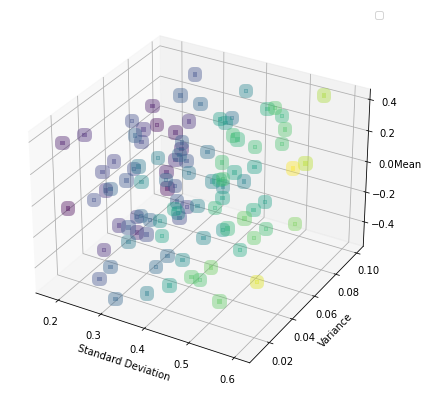

In [571]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(projection='3d')

ax.scatter(arr[:,0],arr[:,1],arr[:,2],alpha=0.4,c=arr[:,0],marker='s',linewidths=10)
#ax.plot(x_b,y_b,z_rl,"ro",alpha=0.5,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)

ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Variance")
ax.set_zlabel("Mean")


# Optimal stddev 1.77822843e-01 
# Optimal variance 2.00000000e-02 
# Optimal mean -1.00000000e-01 



plt.legend()

plt.show()